In [13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip
from scipy.signal import find_peaks
import read_mospy_files as rmp 
import glob
from astropy.convolution import Gaussian2DKernel
from astropy.stats import SigmaClip
from photutils.background import StdBackgroundRMS
from astropy.convolution import convolve
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import simpson
plt.style.use('../cooper-paper.mplstyle')

working on object M_W69492 with zguess =  7.4775 at lambda =  10304.0 AA
check this is the right source: (2289, 6, 41.0, array([50., 50., 50., ..., 50., 50., 50.]), array([2239., 2239., 2239., ..., 2239., 2239., 2239.]), array([2339., 2339., 2339., ..., 2339., 2339., 2339.]), array([2289., 2289., 2289., ..., 2289., 2289., 2289.]), 0, 0, 0.0, 2047.0)
candidate line at  10304.0 AA;  1043 pix
detected at  2.49  sigma


(-7.536516095426446, 15.073032190852892)

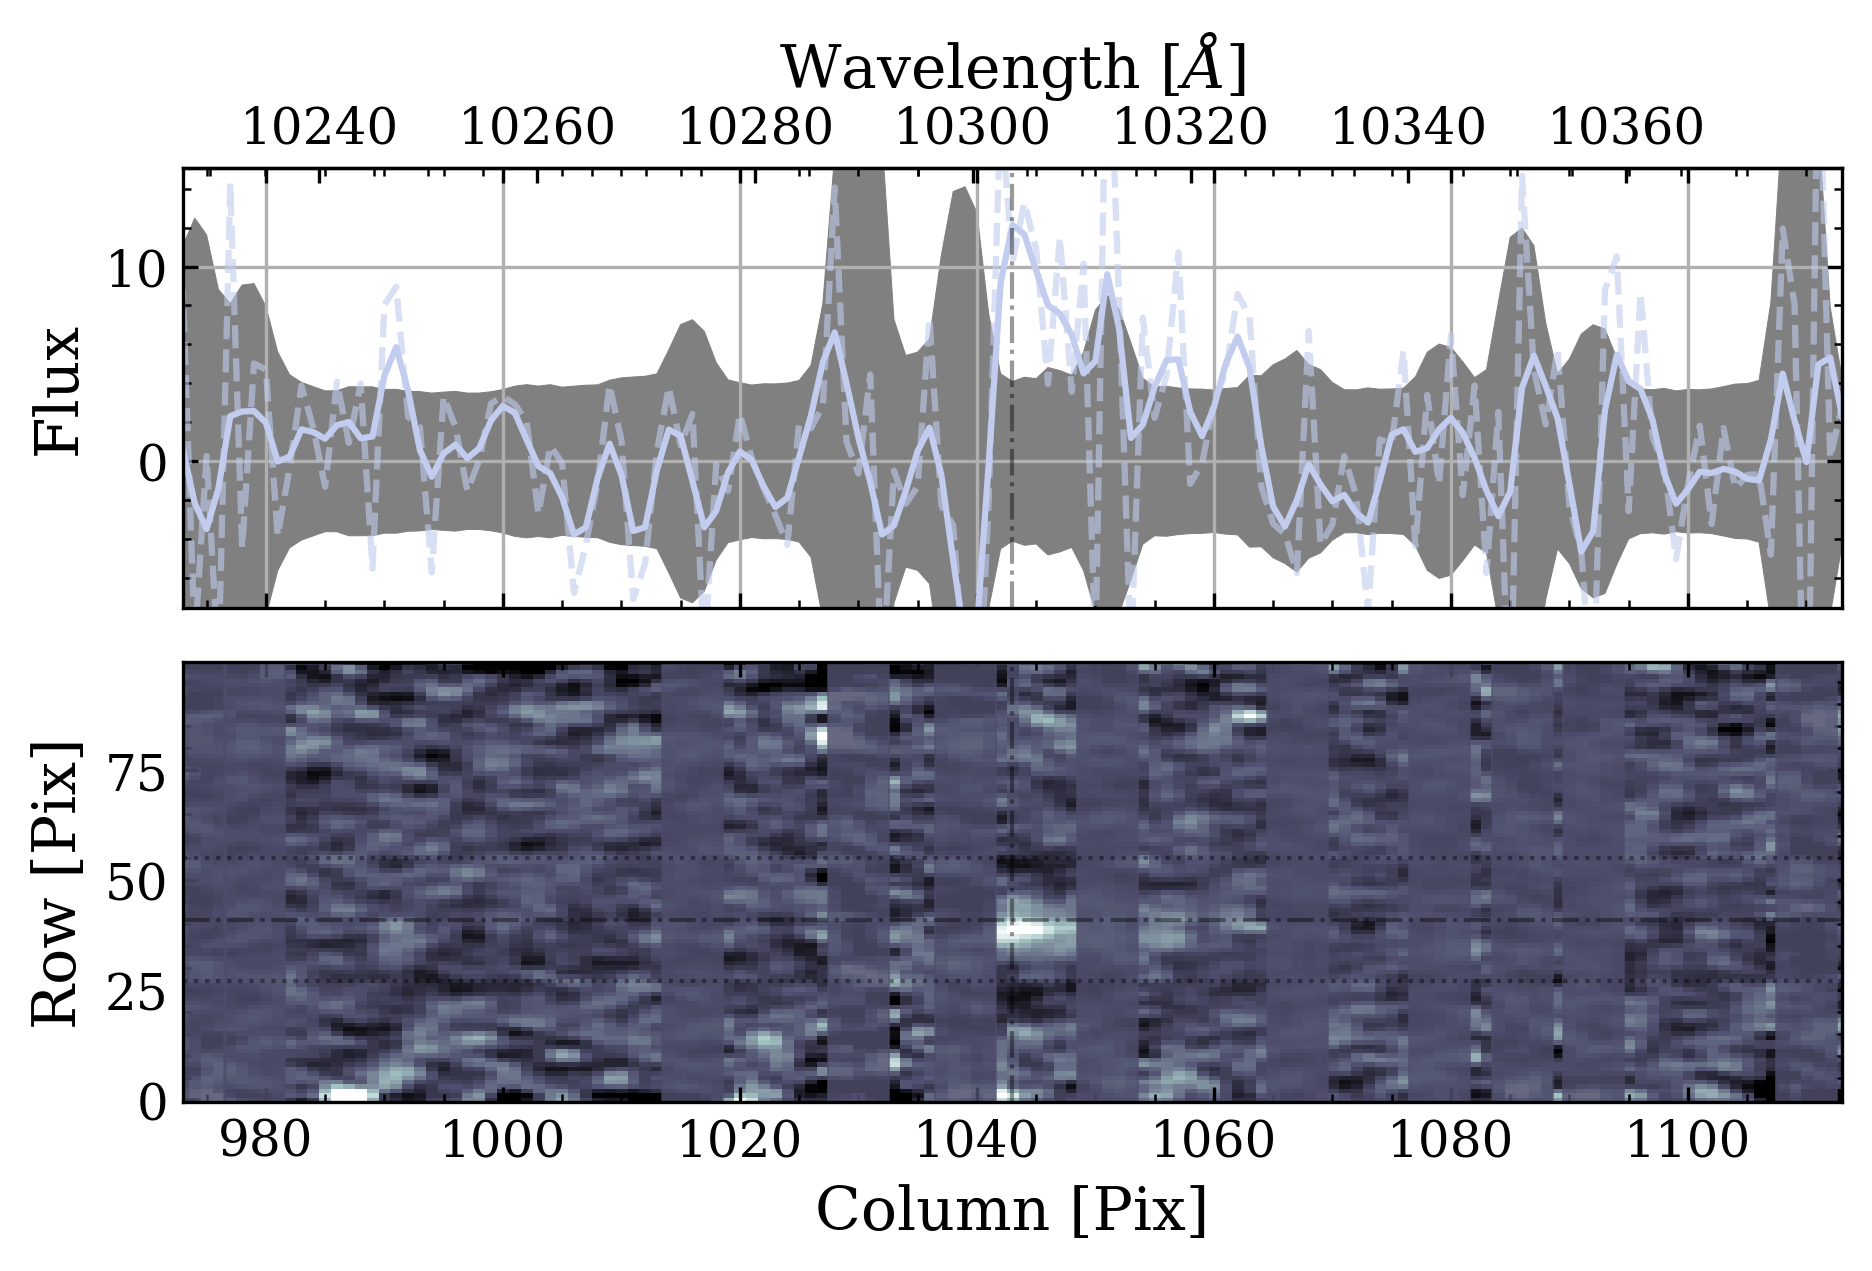

In [2]:
# select object
obj_name = 'M_W69492'
notes = Table.read('cooper_full_notes.csv',format='csv')
idx = np.where(notes['obj']==obj_name)[0]
zguess = float(notes['zguess'][idx])
lguess = float(notes['wave'][idx])
print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')

if notes['mask'][idx] == 'wmmc01':
    ddir = '../wmmc01/'
elif notes['mask'][idx] == 'wmmc02':
    ddir = '../wmmc02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc03':
    ddir = '../wmmc03/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc05':
    ddir = '../wmmc05/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmc06':
    ddir = '../wmmc06/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmmu01':
    ddir = '../wmmu01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme01':
    ddir = '../wmme01/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme02':
    ddir = '../wmme02/pypeit_products/Science_coadd_1x1/'
elif notes['mask'][idx] == 'wmme03':
    ddir = '../wmme03/pypeit_products/Science_coadd_1x1/'
        
### add the other masks


# open 1D and 2D spectrum for an object
tab1 = Table.read(ddir+obj_name+'_1dspec.txt',format='ascii') # created 1d spec txt file from read_pypeit_files.py
file = glob.glob(ddir+'spec2d*.fits')[0] # 2d pypeit image
hdu2 = fits.open(file) # open image
pid = int(notes['pypeit_ref_idx'][idx])-1 # pypeit id to identify the slit
header = hdu2[0].header # header info
signal = hdu2[1].data # signal image data
wave = hdu2[8].data # wave image data
ref = hdu2[10].data[pid] # reference to slit in 2d image
print('check this is the right source:',ref)
x1 = ref[4][0] # left side of slit
x2 = ref[5][0] # right side of slit
xcen = ref[2] # object
sig2d = signal[0:,int(x1):int(x2)].T # signal for the slit (transposed)

pixscale = hdu2[0].header['PSCALE'] # arcsec/pix
nodamparc = 2.5 # arcsec
nodamp = nodamparc/pixscale # nod amplitude in pixels

# gaussian smooth 2D spec
kernel = Gaussian2DKernel(x_stddev=1.)
conv_im = convolve(sig2d, kernel)

### START FIG!
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.subplots_adjust(wspace=0,hspace=0)

# 1D spec
ax1.plot(tab1['pix'],gaussian_filter1d(tab1['opt_counts'],sigma=1),c='#C1CCEE',label=obj_name)
#ax1.plot(tab1['pix'],gaussian_filter1d(tab1['box_counts'],sigma=1),c='m',label=obj_name)
ax1.plot(tab1['pix'],tab1['opt_counts'],c='#C1CCEE',ls='--',alpha=0.6) 
#ax1.plot(tab1['pix'],tab1['box_counts'],c='m',ls='--',alpha=0.6) 
ax1.fill_between(tab1['pix'], y1=tab1['opt_sigma'], y2=-1*tab1['opt_sigma'], color='gray')
#ax1.fill_between(tab1['pix'], y1=tab1['box_sigma'], y2=-1*tab1['opt_sigma'], color='gray', alpha=0.2)
ax1.set_ylabel(r'Flux')

# 2D spec
lower=-1; upper=2
sample = sigma_clip(sig2d) 
vmin = sample.mean() + lower * sample.std()
vmax = sample.mean() + upper * sample.std()
ax2.imshow(conv_im, origin='lower', cmap='bone', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_xlabel('Column [Pix]')
ax2.set_ylabel('Row [Pix]')
ax2.grid(False)

# block out sky lines 2D
ipk = find_peaks(tab1['opt_sigma'], height=np.mean(tab1['opt_sigma']))[0]
for i in ipk:
    ax2.axvline(tab1['pix'][i],c='#4D4D6B',lw=15,alpha=0.85)

    
# secax = secondary axis for wavelength space
def forward(x):
    return np.interp(x, tab1['pix'], tab1['lambda'])

def inverse(x):
    return np.interp(x, tab1['lambda'], tab1['pix'])

secax = ax1.secondary_xaxis('top', functions=(forward, inverse))
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel(r'Wavelength [$\AA$]')

# mark measured line at pixel guess based on lambda guess
pguess = tab1['pix'][rmp.closest(tab1['lambda'],lguess)[0]] # pixel closest to wavelength of line to center on
s = tab1['opt_counts'][rmp.closest(tab1['lambda'],lguess)[0]] # signal closest to wavelength of line
n = tab1['opt_sigma'][rmp.closest(tab1['lambda'],lguess)[0]] # error closest to wavelength of line
sn = np.round(s/n,2)
print("candidate line at ",lguess,'AA; ',pguess,'pix')
print("detected at ",sn,' sigma')
ax1.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axvline(pguess,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen,lw=1,c='k',ls='-.',alpha=0.4)
ax2.axhline(xcen+nodamp,lw=1,c='k',ls=':',alpha=0.4)
ax2.axhline(xcen-nodamp,lw=1,c='k',ls=':',alpha=0.4)


ax1.set_xlim(pguess-70,pguess+70)
ax2.set_xlim(pguess-70,pguess+70)
ax1.set_ylim(-2*np.nanmedian(tab1['opt_sigma']),4*np.nanmedian(tab1['opt_sigma']))

estimate the sigma of the line
- [ ] mc the noise from just a gaussian (don't worry about scaling) x1000
- [ ] then convolve with fwhm (sky line width)
- [ ] then rescale based on median rms of actual noise
- [ ] then take integral for line signal and mc noise - mask out sky lines
- [ ] the obs noise should encompass 68% of the mc noise (1 sigma error)

- generate random gaussian noise along spectral axis
- convolve with spectral resolution of instrument - gaussian of width (R --> AA), measure width of spectral lines from sky lines, it'll be diff for 0.7" or 1". two superimposed gaussians and you'll need to scale by snr of each roughly and coadd to get the new fwhm
- renormalize to 1sigma of real observed noise
- integrate under that curve, just around the line plus a healthy bit, and mask out sky lines
- integrate under actual spectrum
- then do 1000x with diff noise spectra

In [3]:
from scipy.optimize import curve_fit

def gaussian(xaxis, mean, A, sig, offset): 
	'''
	Simple Gaussian function, to be used in the quick optimized extraction
	'''
	return A * np.exp(-np.power(xaxis-mean, 2.) / (2*np.power(sig, 2.))) + offset

In [4]:
box = tab1['box_counts']; err = tab1['box_sigma']
opt = tab1['opt_counts']; opterr = tab1['opt_sigma']
wav = tab1['lambda']
sky = tab1['sky_counts']

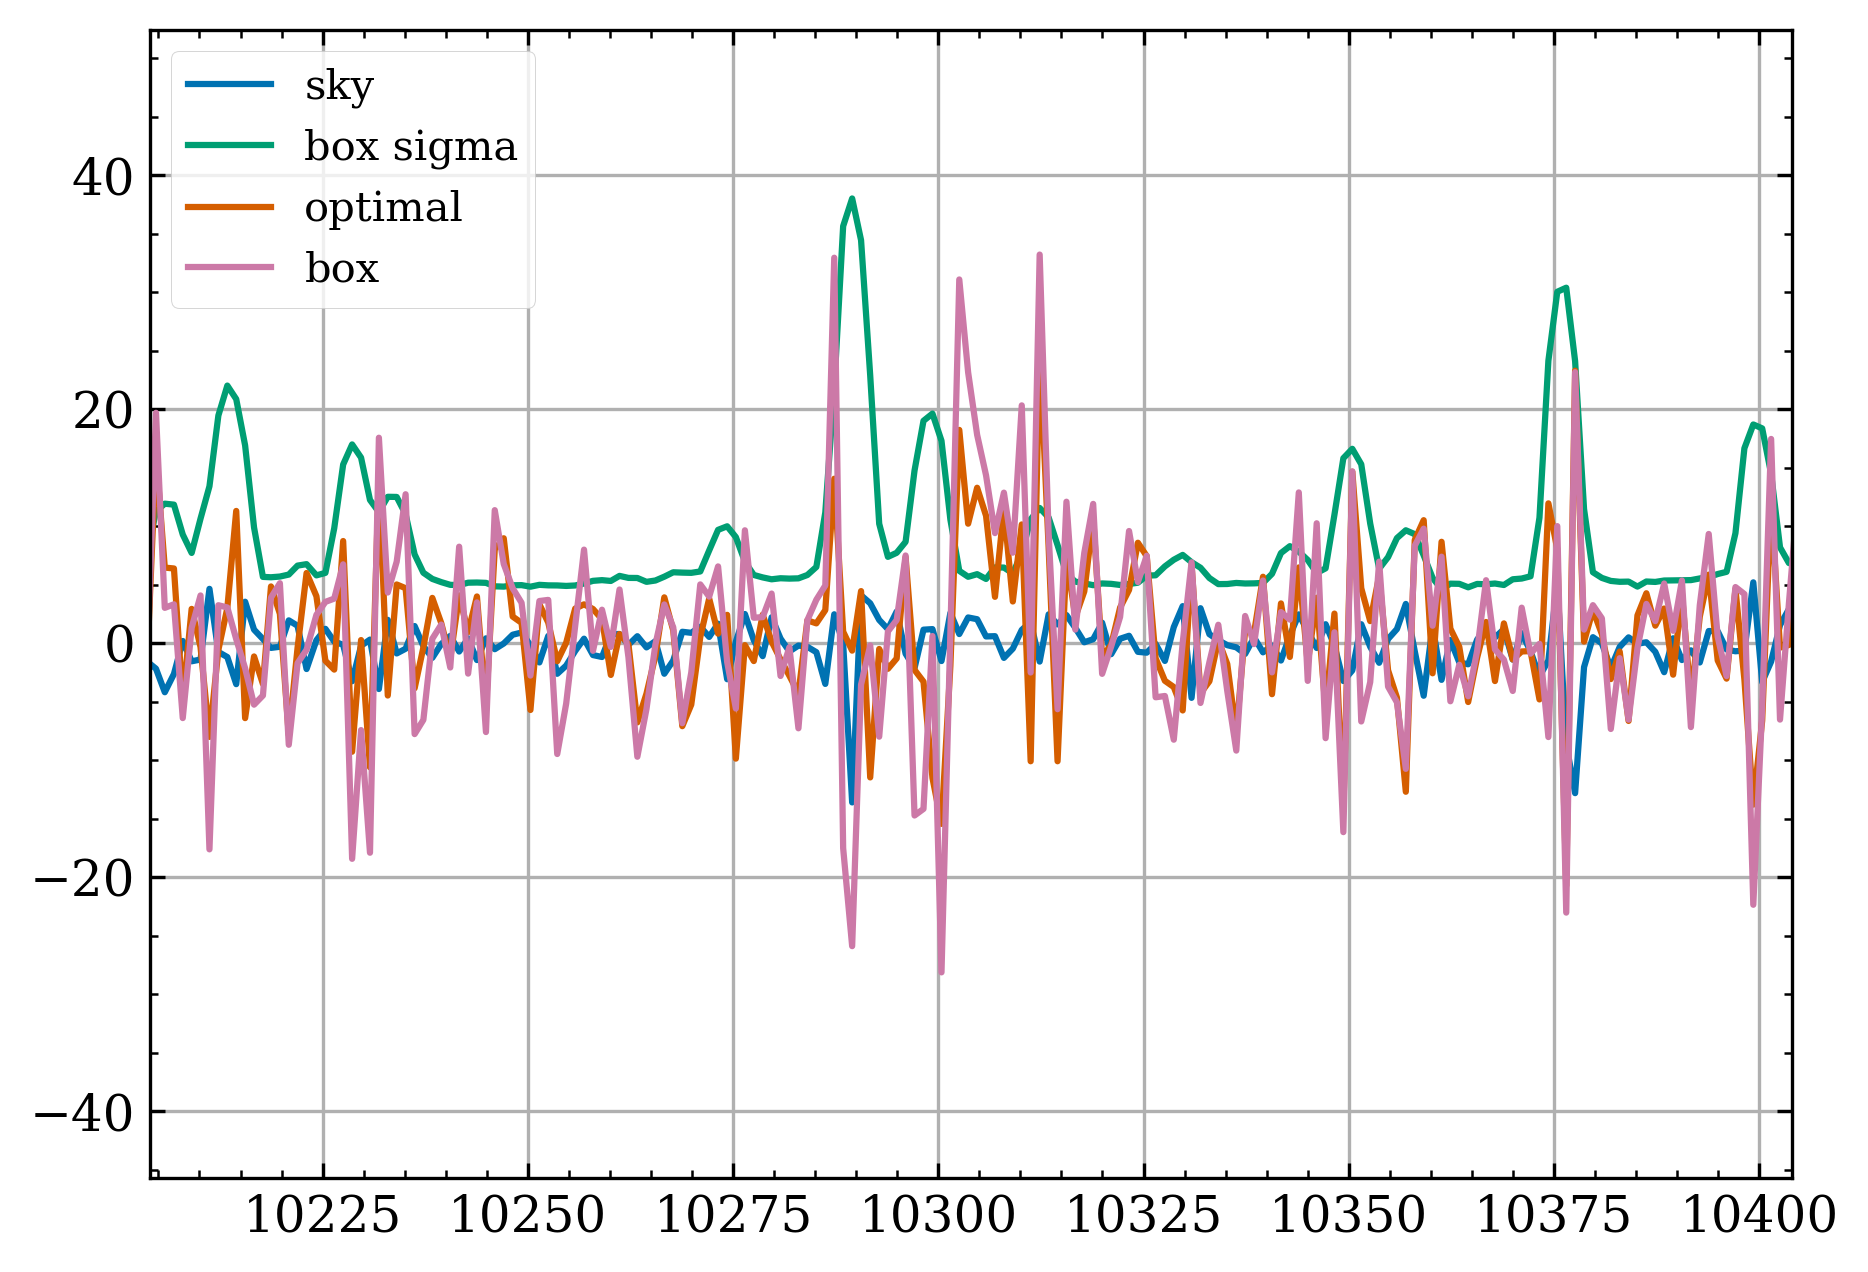

In [24]:
plt.plot(wav,sky,label='sky')
plt.plot(wav,err,label='box sigma')
plt.plot(wav,opt,label='optimal')
plt.plot(wav,box,label='box')

plt.xlim(lguess-100,lguess+100)
plt.legend()

In [25]:
y = err[1142:1160]
x = range(len(y))
popt, pvoc = curve_fit(gaussian, x, y, p0=[8,35,3,0])
sigma = popt[2]
fwhm = 2.355*sigma
print(fwhm)

3.589150301905392


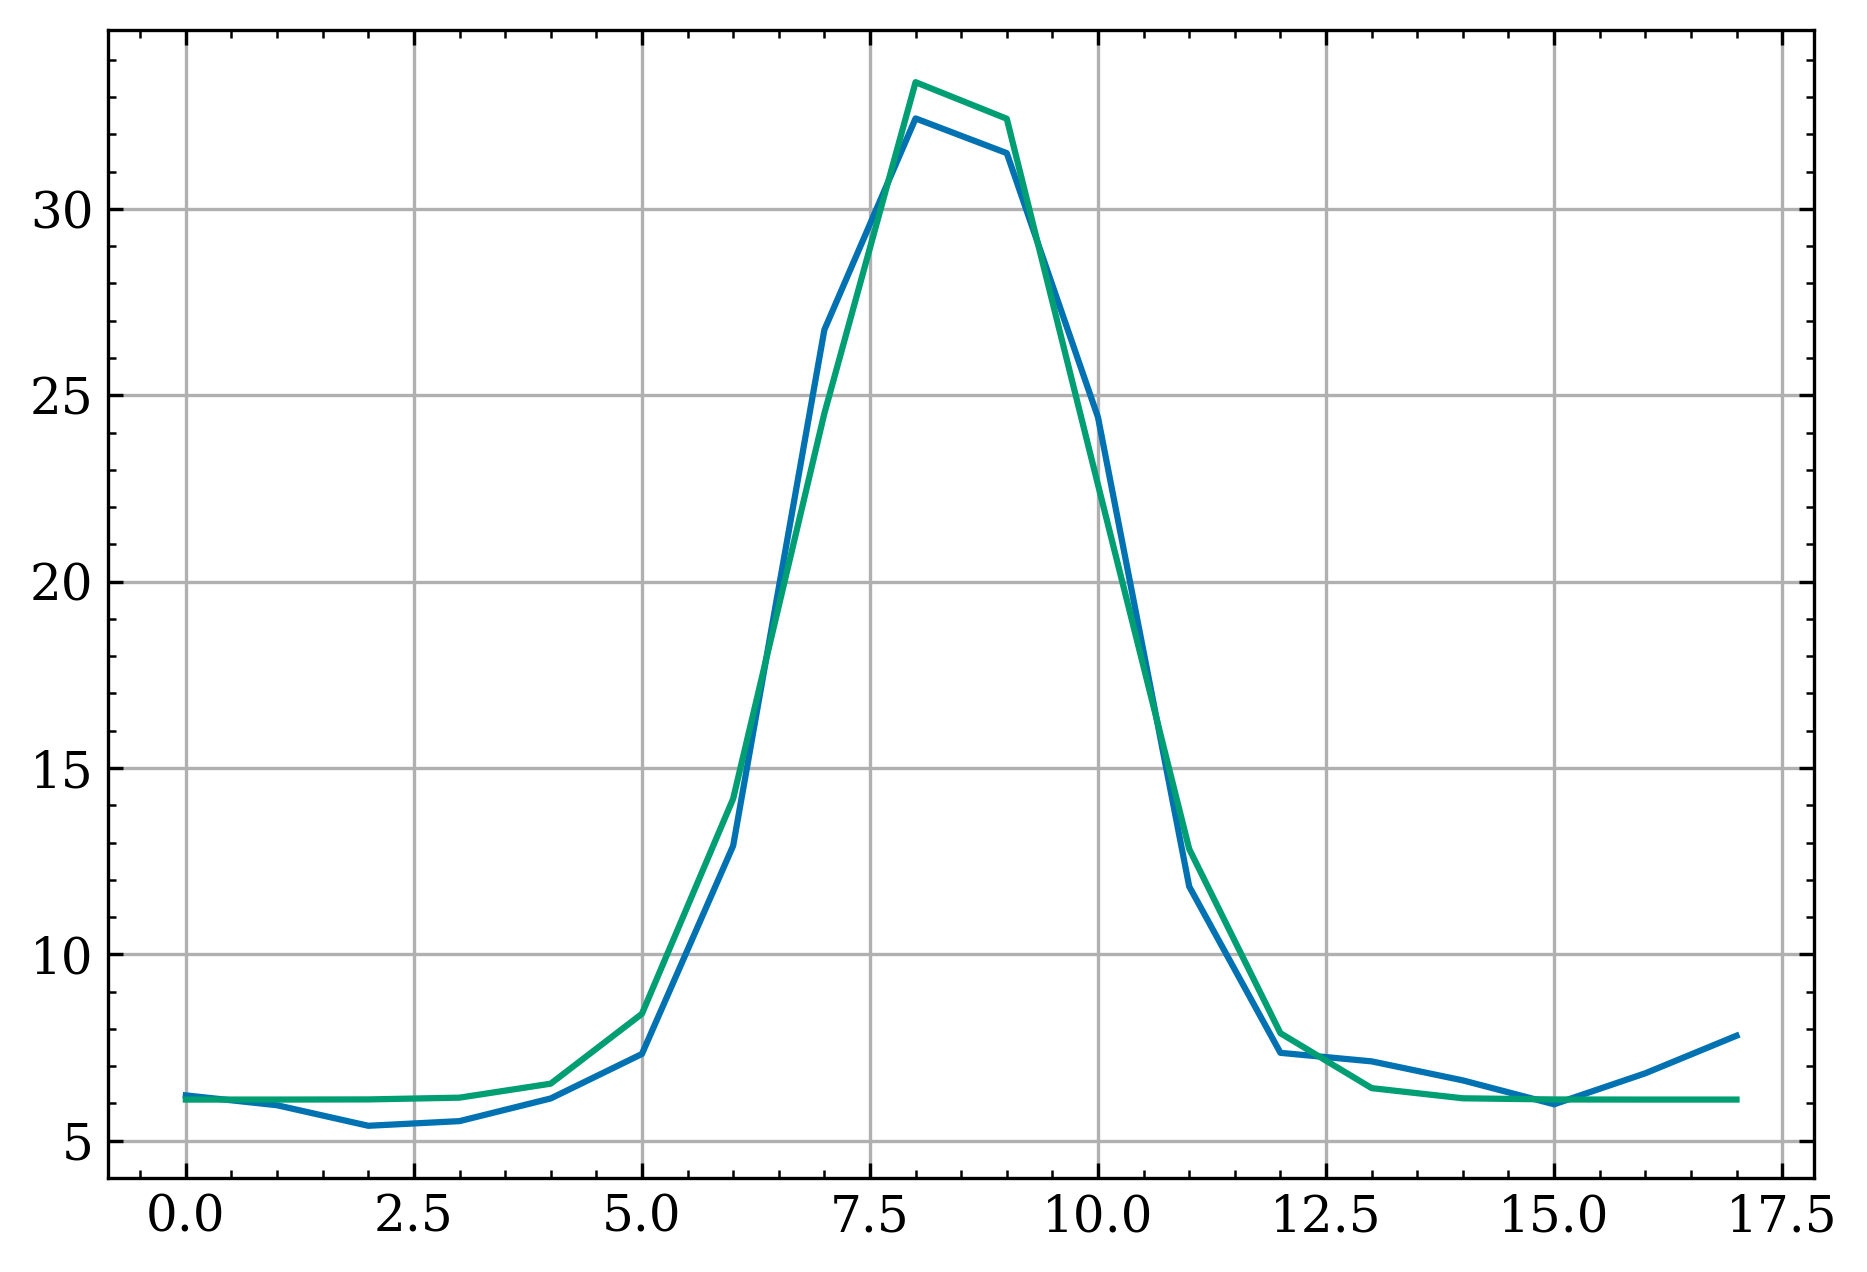

In [26]:
plt.plot(x,y)
yfit = gaussian(x, popt[0], popt[1], popt[2], popt[3])
plt.plot(x,yfit)

In [35]:
# block out sky lines 2D
ipk = find_peaks(err, height=np.median(err))[0]
mwidth = 2

mask = np.ones(err.size, dtype=bool)
for n in range(-int(mwidth/2),int(mwidth/2)+1):
    ind = ipk + n
    mask[ind] = False

(10234.0, 10374.0)

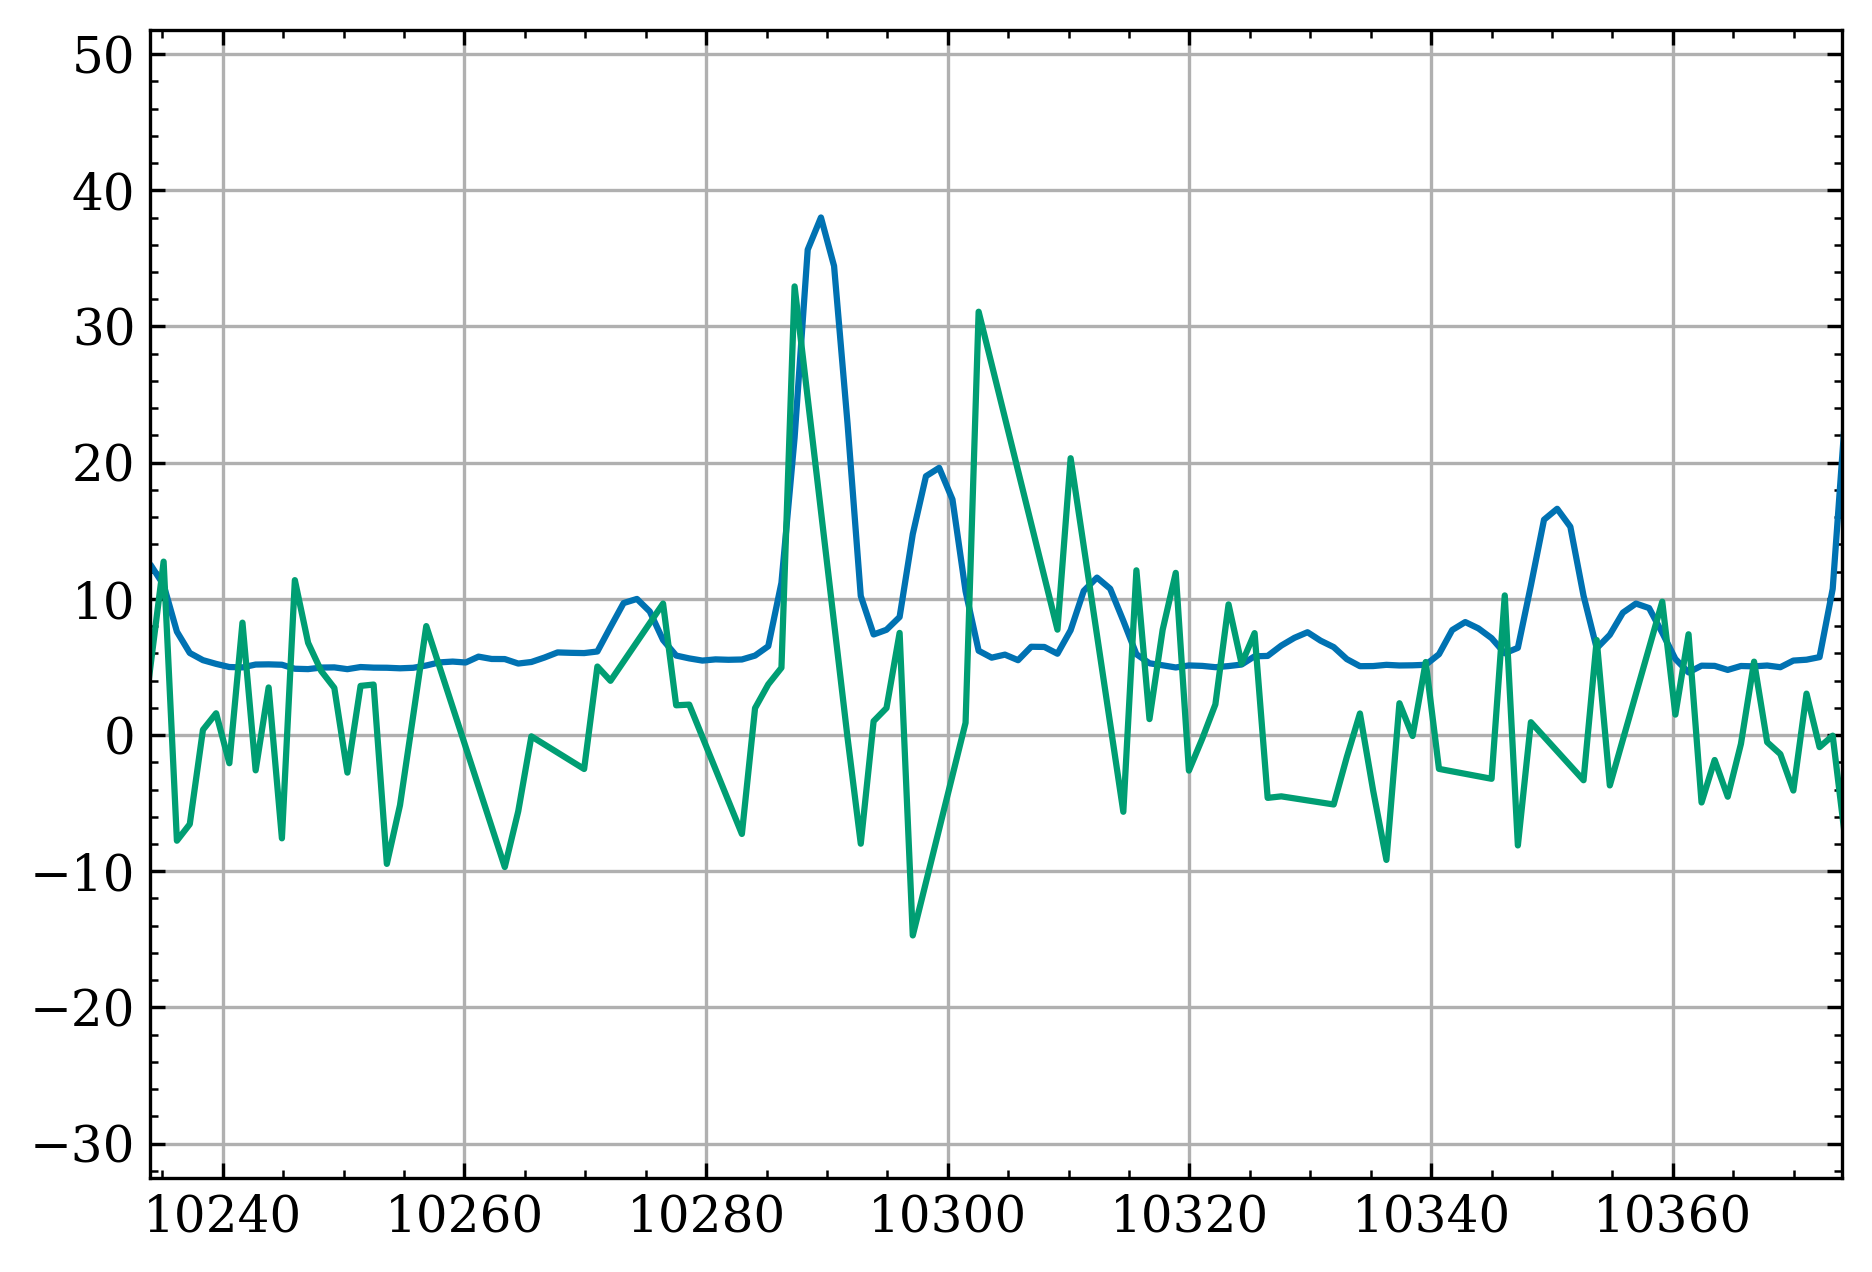

In [36]:
plt.plot(wav,err)
plt.plot(wav[mask],box[mask])
plt.xlim(lguess-70,lguess+70)

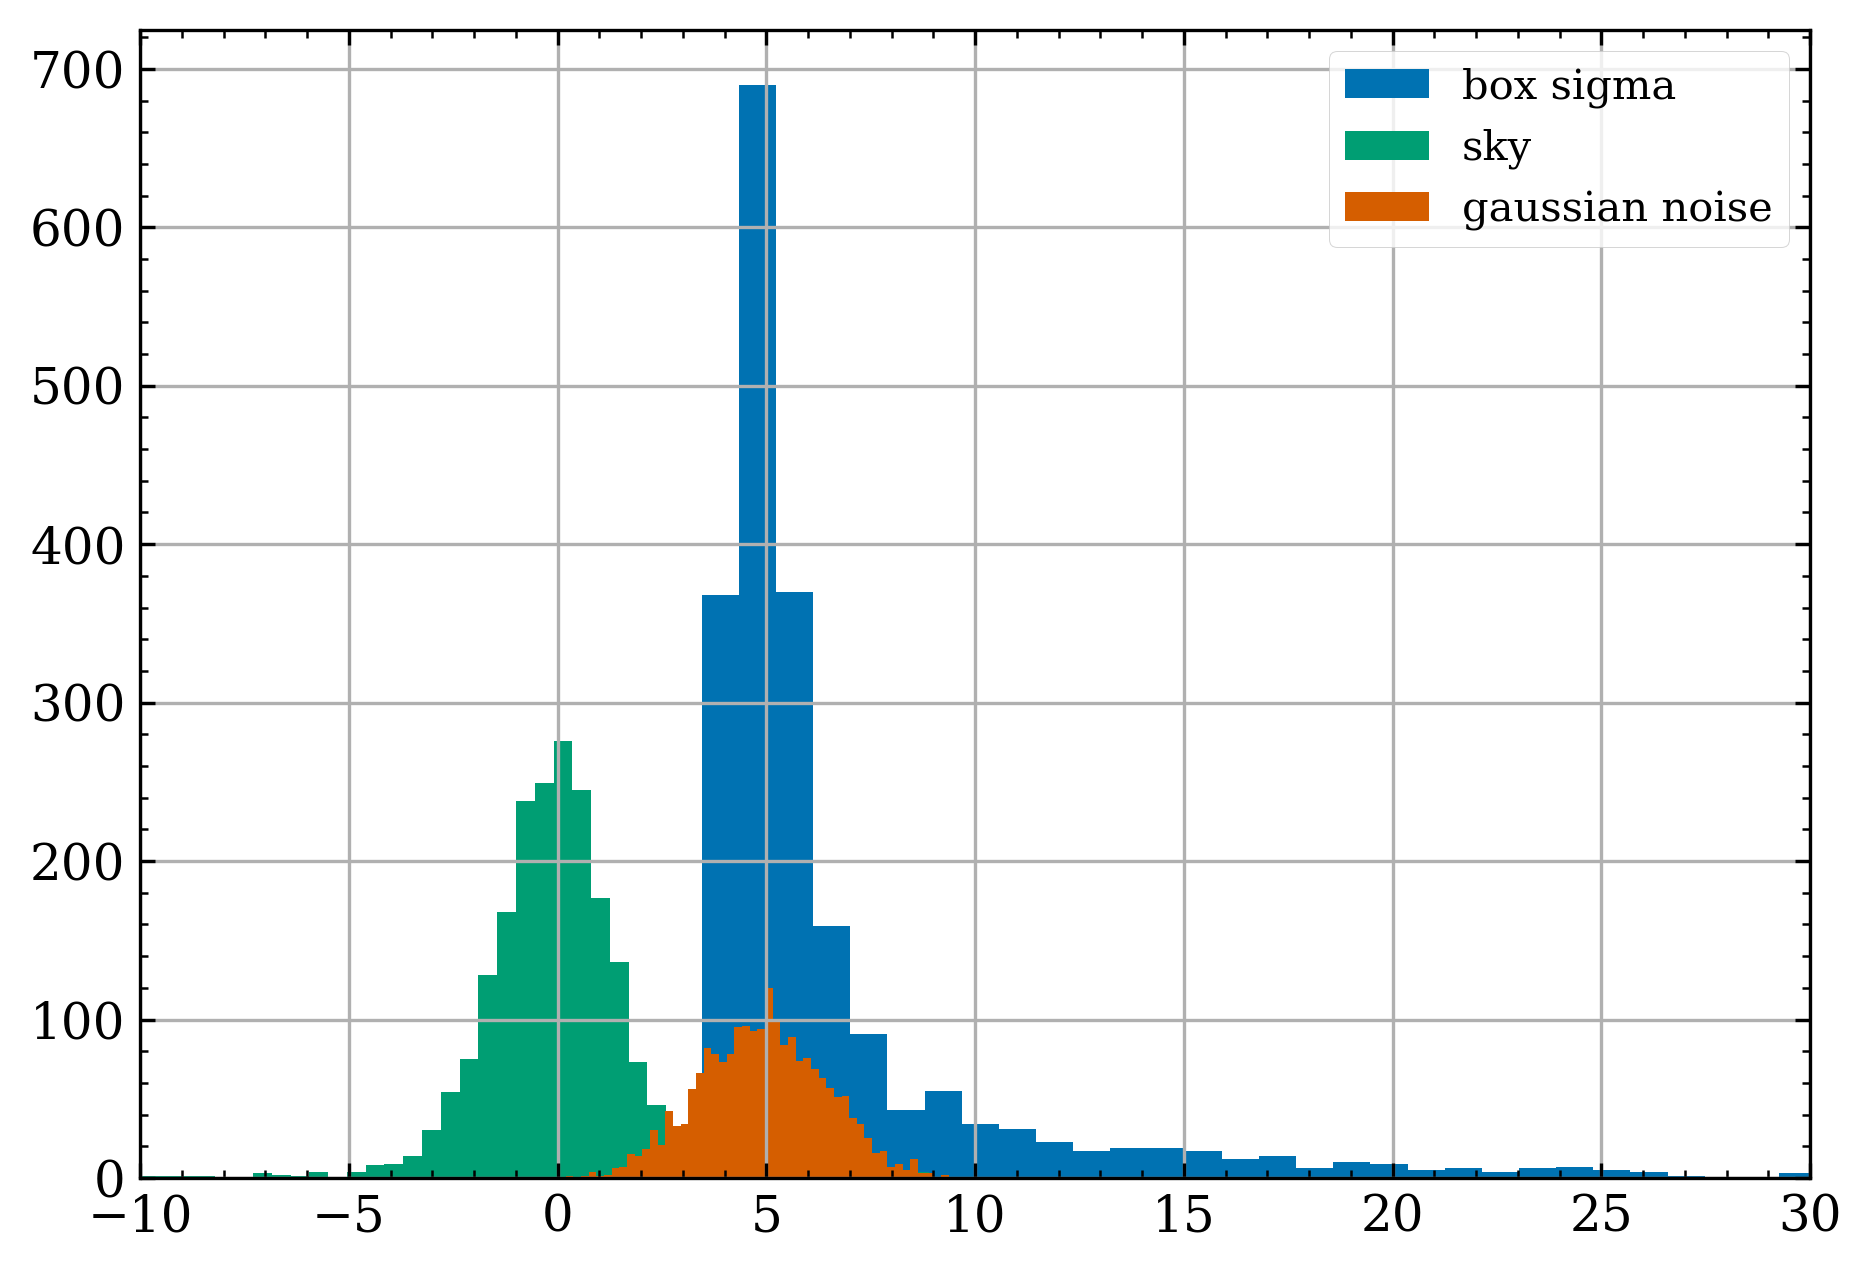

In [81]:
mcnoise = np.random.normal(np.median(err[mask]),sigma,size=len(err))

plt.hist(err,bins=50,label='box sigma')
plt.hist(sky,bins=50,label='sky')
plt.hist(mcnoise,bins=50,label='gaussian noise')
plt.xlim(-10,30)
plt.legend()
plt.show()

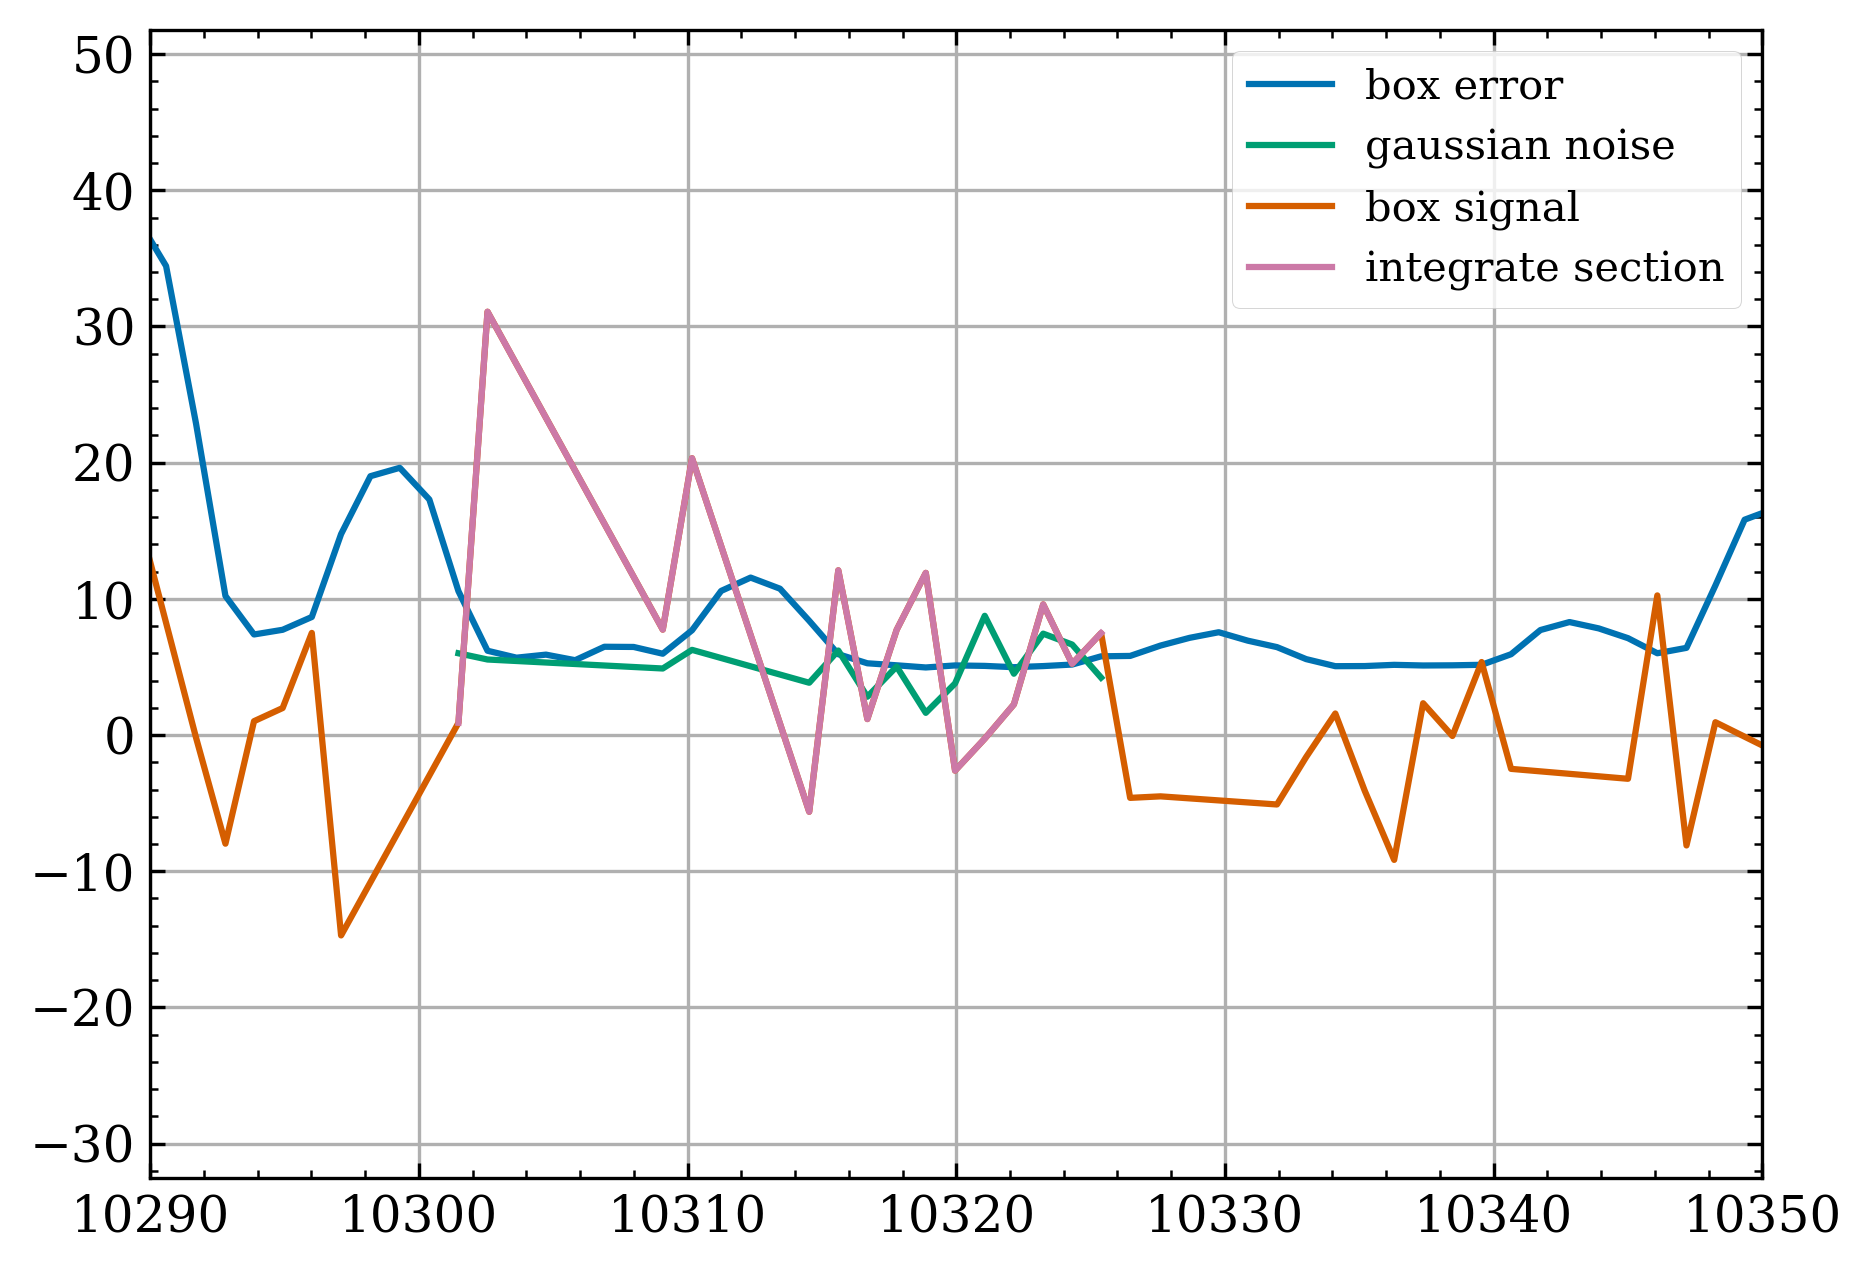

In [61]:
left = 813; right = 828
maskwav = wav[mask].copy()
maskbox = box[mask].copy()
maskmc = mcnoise[mask].copy()

plt.plot(wav,err,label='box error')
plt.plot(maskwav[left:right],maskmc[left:right],label='gaussian noise')
plt.plot(wav[mask],box[mask],label='box signal')
plt.plot(maskwav[left:right],maskbox[left:right],label='integrate section')
plt.xlim(10290,10350)
plt.legend()

(4.097492061861866, 4.236156026821502)

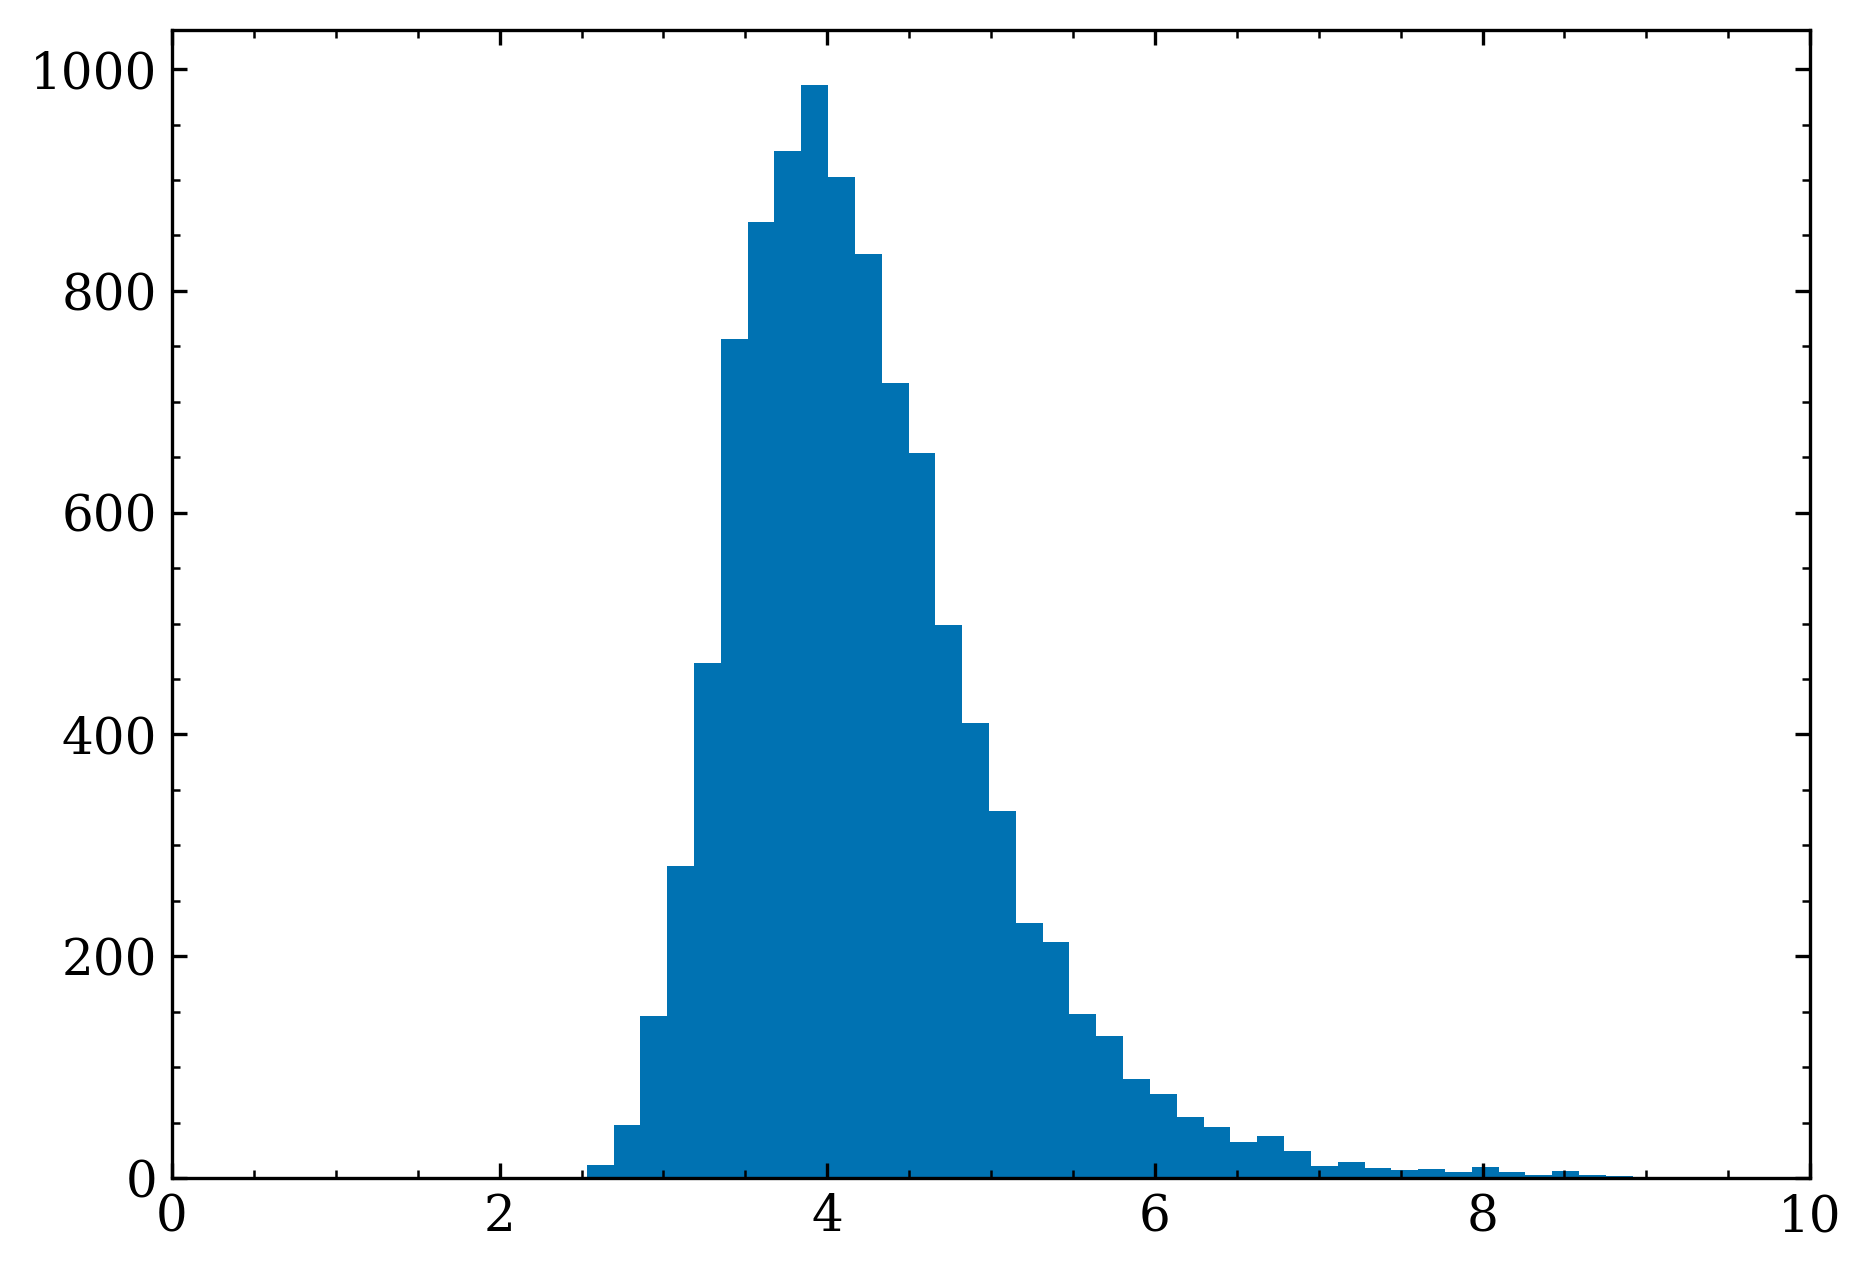

In [80]:
trials = 10000
maskwav = wav[mask].copy()
maskbox = box[mask].copy()
maskerr = err[mask].copy()

snr = []
for t in range(trials):
    mcnoise = np.random.normal(np.median(maskerr),sigma,size=len(err))
    maskmc = mcnoise[mask].copy()
    s = simpson(maskbox[left:right],x=maskwav[left:right])
    n = simpson(maskmc[left:right],x=maskwav[left:right])
    snr.append(s/n)

plt.hist(snr,bins=50)
plt.grid(False)
plt.xlim(0,10)
np.median(snr), np.mean(snr)

In [250]:
def linesnr(obj_name,left,right,trials=2):
    """
    
    
    """
    
    
    # select object
    notes = Table.read('cooper_full_notes.csv',format='csv')
    idx = np.where(notes['obj']==obj_name)[0]
    zguess = float(notes['zguess'][idx])
    lguess = float(notes['wave'][idx])
    print('working on object',obj_name,'with zguess = ',zguess,'at lambda = ',lguess,'AA')

    if notes['mask'][idx] == 'wmmc01':
        ddir = '../wmmc01/'
    elif notes['mask'][idx] == 'wmmc02':
        ddir = '../wmmc02/pypeit_products/Science_coadd_1x1/'
    elif notes['mask'][idx] == 'wmmc03':
        ddir = '../wmmc03/pypeit_products/Science_coadd_1x1/'
    elif notes['mask'][idx] == 'wmmc05':
        ddir = '../wmmc05/pypeit_products/Science_coadd_1x1/'
    elif notes['mask'][idx] == 'wmmc06':
        ddir = '../wmmc06/pypeit_products/Science_coadd_1x1/'
    elif notes['mask'][idx] == 'wmmu01':
        ddir = '../wmmu01/pypeit_products/Science_coadd_1x1/'
    elif notes['mask'][idx] == 'wmme01':
        ddir = '../wmme01/pypeit_products/Science_coadd_1x1/'
    elif notes['mask'][idx] == 'wmme02':
        ddir = '../wmme02/pypeit_products/Science_coadd_1x1/'
    elif notes['mask'][idx] == 'wmme03':
        ddir = '../wmme03/pypeit_products/Science_coadd_1x1/'
        
    # open 1D spectrum for an object
    tab1 = Table.read(ddir+obj_name+'_1dspec.txt',format='ascii') # created 1d spec txt file from read_pypeit_files.py
    box = tab1['box_counts']; err = tab1['box_sigma']
    opt = tab1['opt_counts']; opterr = tab1['opt_sigma']
    wav = tab1['lambda']
    
    # block out sky lines
    ipk = find_peaks(err, height=np.median(err))[0]
    mwidth = 2

    mask = np.ones(err.size, dtype=bool)
    for n in range(-int(mwidth/2),int(mwidth/2)+1):
        ind = ipk + n
        mask[ind] = False

    plt.clf()
    plt.plot(wav,sky,label='sky')
    plt.plot(wav,opterr,label='opt sigma')
    plt.plot(wav,opt,label='optimal')
    plt.xlim(lguess-100,lguess+100)
    plt.legend()
    plt.show()
    
    y = err[1142:1160]
    x = range(len(y))
    popt, pvoc = curve_fit(gaussian, x, y, p0=[8,35,3,0])
    sigma = popt[2]
    fwhm = 2.355*sigma
    print("fwhm of sky line:",fwhm)
    
    plt.clf()
    plt.plot(x,y)
    yfit = gaussian(x, popt[0], popt[1], popt[2], popt[3])
    plt.plot(x,yfit)
    plt.show()
    
    maskwav = wav[mask].copy()
    maskbox = box[mask].copy()
    
    snr = []
    for t in range(trials):
        mcnoise = np.random.normal(np.std(box[mask]),fwhm,size=len(err))
        maskmc = mcnoise[mask].copy()
        s = simpson(maskbox[left:right],x=maskwav[left:right])
        n = simpson(maskmc[left:right],x=maskwav[left:right])
        snr.append(s/n)
        
    return snr

working on object M_W69492 with zguess =  7.4775 at lambda =  10304.0 AA


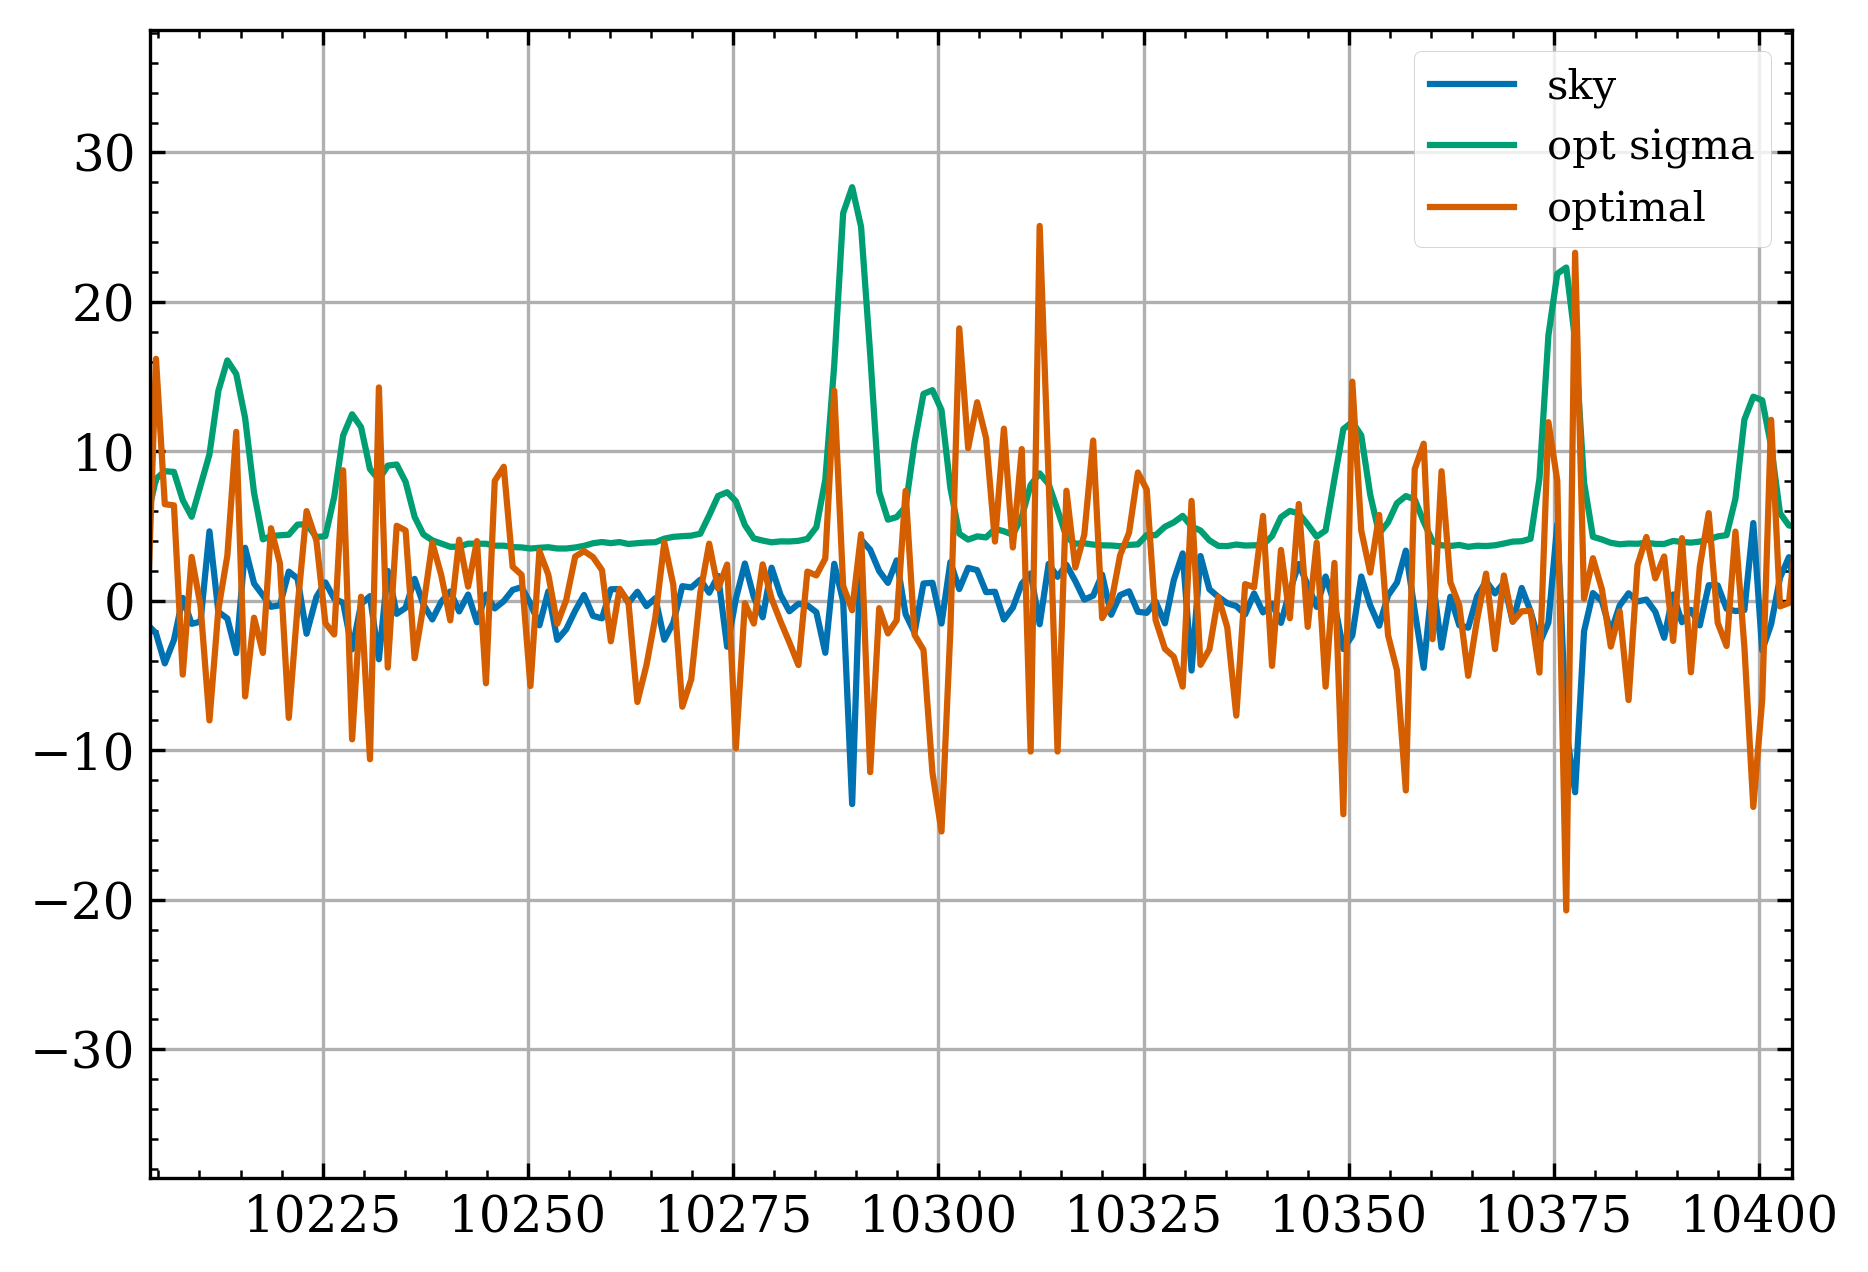

fwhm of sky line: 3.589150301905392


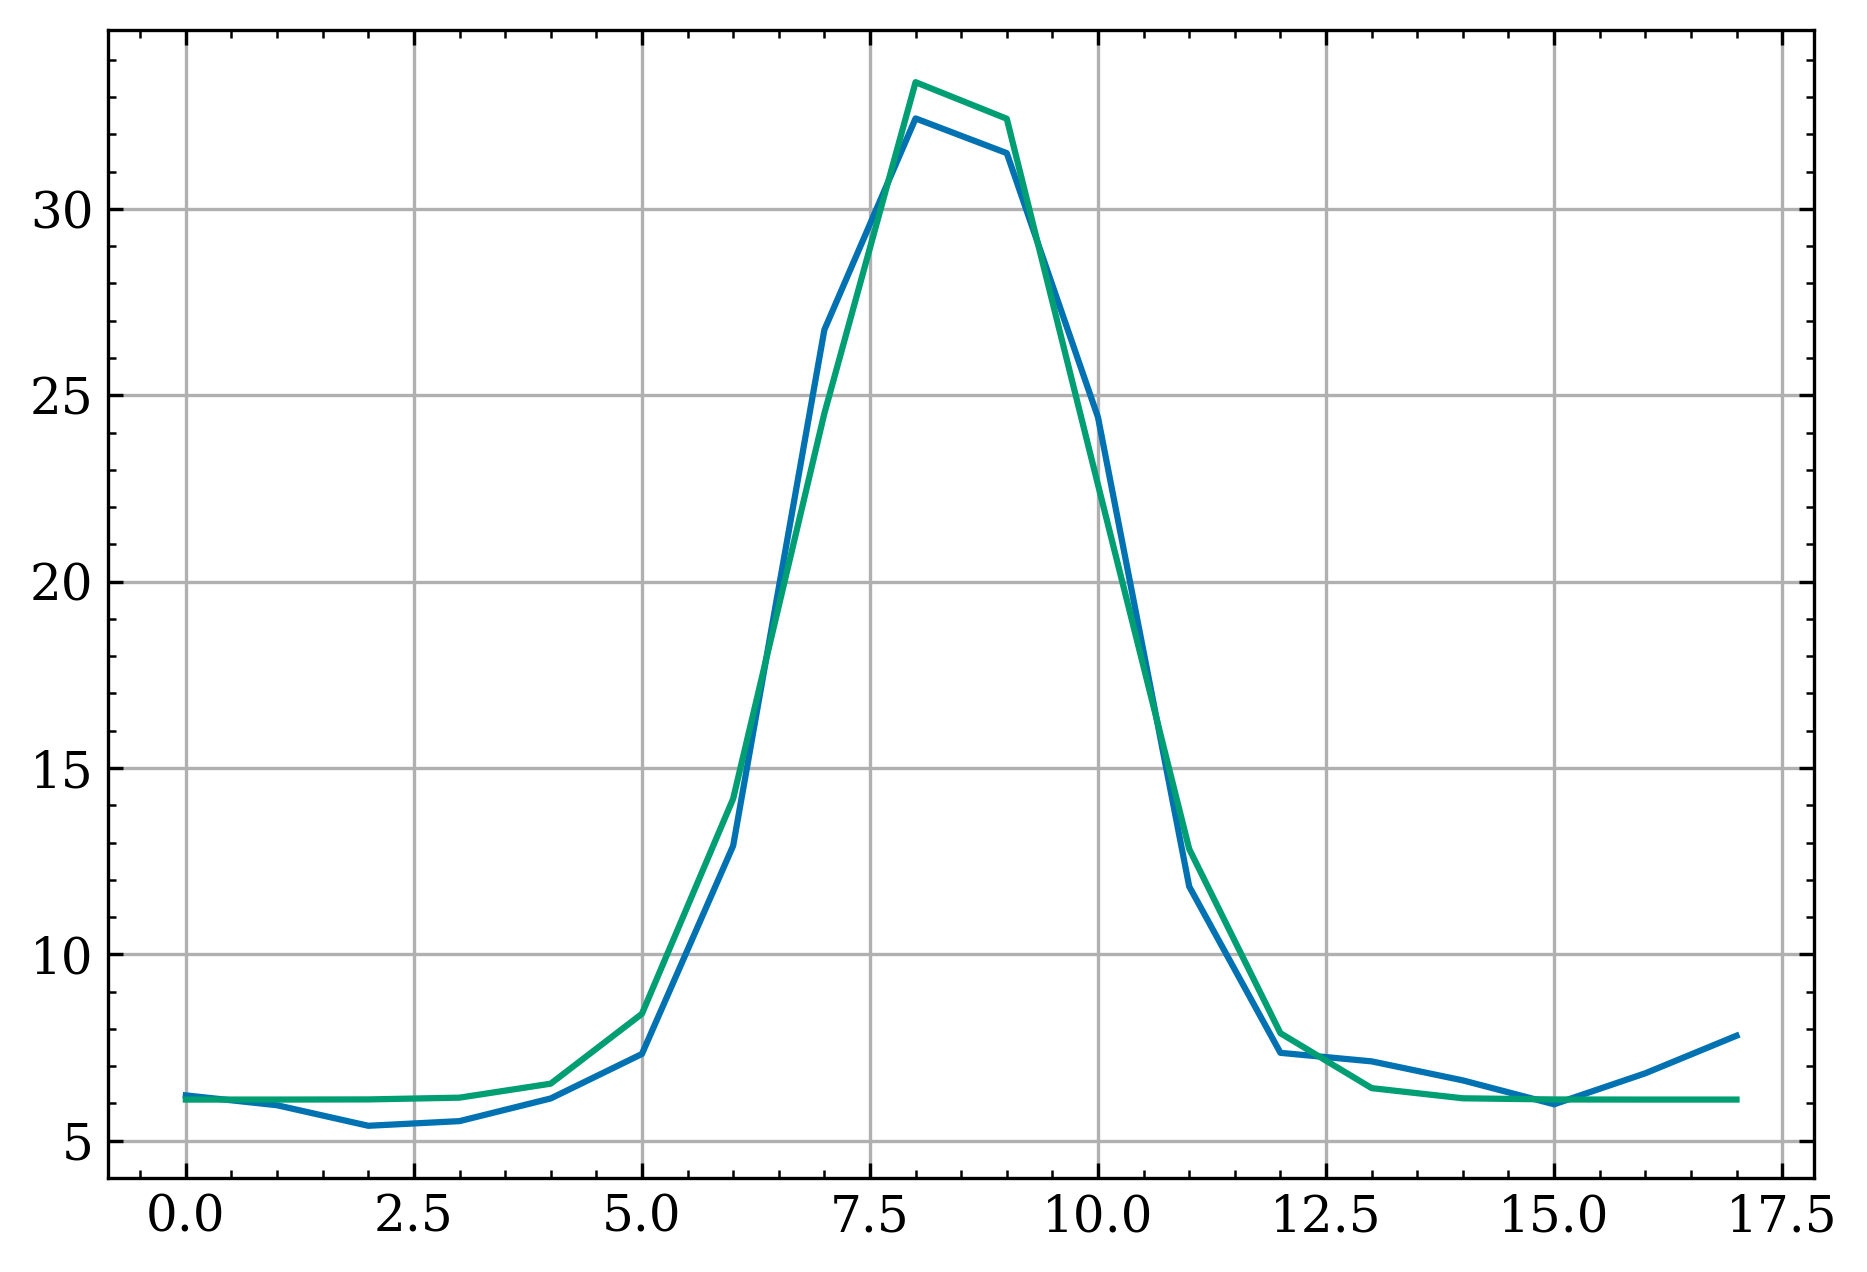

In [251]:
snrs = linesnr(obj_name,left,right,trials=1000)

In [252]:
np.mean(snrs)

4.2762610754245625